# Chronic Heart Diseases Classification



In this section, we perform exploratory data analysis (EDA) and train a machine learning model using Python. The code includes the necessary imports for data manipulation, visualization, statistical analysis, and machine learning.

## Libraries Used

- `random`: Python module for generating random numbers.
- `pandas (pd)`: Data manipulation and analysis library.
- `numpy (np)`: Library for numerical operations on arrays and matrices.
- `matplotlib.pyplot as plt`: Visualization library for creating static, animated, and interactive plots.
- `seaborn (sns)`: Data visualization library based on Matplotlib that provides a high-level interface.
- `scipy.stats`: Library for statistical functions.
- `statsmodels.stats.outliers_influence.variance_inflation_factor`: VIF calculation for multicollinearity.
- `statsmodels.tools.tools.add_constant`: Function to add a constant term to the predictor.
- `sklearn.model_selection.GridSearchCV`: Grid search with cross-validation for hyperparameter tuning.
- `sklearn.metrics`: Evaluation metrics for machine learning models.
- `sklearn.svm.SVC`: Support Vector Classification model.
- `sklearn.tree.DecisionTreeClassifier`: Decision Tree classifier.
- `sklearn.ensemble.AdaBoostClassifier`: AdaBoost classifier.
- `warnings.filterwarnings`: Control warnings for displaying or ignoring.

## Code Explanation

The code begins by setting up the necessary libraries and configuring warning filters to ignore them during execution. It then proceeds with data analysis and machine learning model training.

Note: Ensure that the required datasets are loaded before running this code cell.



In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import AdaBoostClassifier
from warnings import filterwarnings

filterwarnings('ignore')

## Custom Scorer Function

The following code defines a custom scoring function named `custom_scorer`. This function is designed to handle potential exceptions that may occur during the calculation of a specified scoring metric.

## MCC
The Matthews Correlation Coefficient (MCC) is a metric used for evaluating the performance of binary and multiclass classification models. It takes into account true positive (TP), true negative (TN), false positive (FP), and false negative (FN) values and produces a score between -1 and +1.


In [2]:
def custom_scorer(y_true, y_pred, actual_scorer):
    score = np.nan
    try: score = actual_scorer(y_true, y_pred)
    except Exception: pass
    return score

mcc = make_scorer(custom_scorer, actual_scorer = matthews_corrcoef)

### EDA

Now we can load the dataset and do the exploratory data analysis

In [3]:
heart_df = pd.read_csv('framingham.csv', engine = 'python')
heart_df = heart_df.dropna(axis = 0)


heart_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
heart_df.rename(columns={"currentSmoker": "current_smoker",
                         "cigsPerDay": "cigs_per_day",
                         "BPMeds": "bp_meds",
                         "prevalentStroke": "prevalent_stroke",
                         "prevalentHyp": "prevalent_hyper",
                         "totChol": "total_chol",
                         "sysBP": "sys_bp",
                         "diaBP": "dia_bp",
                         "BMI": "bmi",
                         "heartRate": "heart_rate",
                         "TenYearCHD": "ten_year_chd"}, inplace=True)


In [5]:
heart_df['male'] = heart_df['male'].astype('category')
heart_df['education'] = heart_df['education'].astype('category')
heart_df['current_smoker'] = heart_df['current_smoker'].astype(int).astype('category')
heart_df['bp_meds'] = heart_df['bp_meds'].astype(int).astype('category')
heart_df['prevalent_stroke'] = heart_df['prevalent_stroke'].astype(int).astype('category')
heart_df['prevalent_hyper'] = heart_df['prevalent_hyper'].astype(int).astype('category')
heart_df['diabetes'] = heart_df['diabetes'].astype(int).astype('category')
heart_df['ten_year_chd'] = heart_df['ten_year_chd'].astype(int).astype('category')

In [6]:
heart_df.select_dtypes(exclude = ['category']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,3658.0,49.551941,8.562029,32.00,42.00,49.00,56.0000,70.0
cigs_per_day,3658.0,9.025424,11.921590,0.00,0.00,0.00,20.0000,70.0
total_chol,3658.0,236.847731,44.097681,113.00,206.00,234.00,263.0000,600.0
sys_bp,3658.0,132.370558,22.086866,83.50,117.00,128.00,143.8750,295.0
dia_bp,3658.0,82.917031,11.974258,48.00,75.00,82.00,90.0000,142.5
bmi,3658.0,25.782802,4.065601,15.54,23.08,25.38,28.0375,56.8
heart_rate,3658.0,75.730727,11.981525,44.00,68.00,75.00,82.0000,143.0
glucose,3658.0,81.852925,23.904164,40.00,71.00,78.00,87.0000,394.0


In [7]:
heart_df.select_dtypes(include = ['category']).describe().transpose()

,count,unique,top,freq
male,3658.0,2.0,0.0,2035.0
education,3658.0,4.0,1.0,1526.0
current_smoker,3658.0,2.0,0.0,1869.0
bp_meds,3658.0,2.0,0.0,3547.0
prevalent_stroke,3658.0,2.0,0.0,3637.0
prevalent_hyper,3658.0,2.0,0.0,2518.0
diabetes,3658.0,2.0,0.0,3559.0
ten_year_chd,3658.0,2.0,0.0,3101.0


## Now Lets do Data Visualization

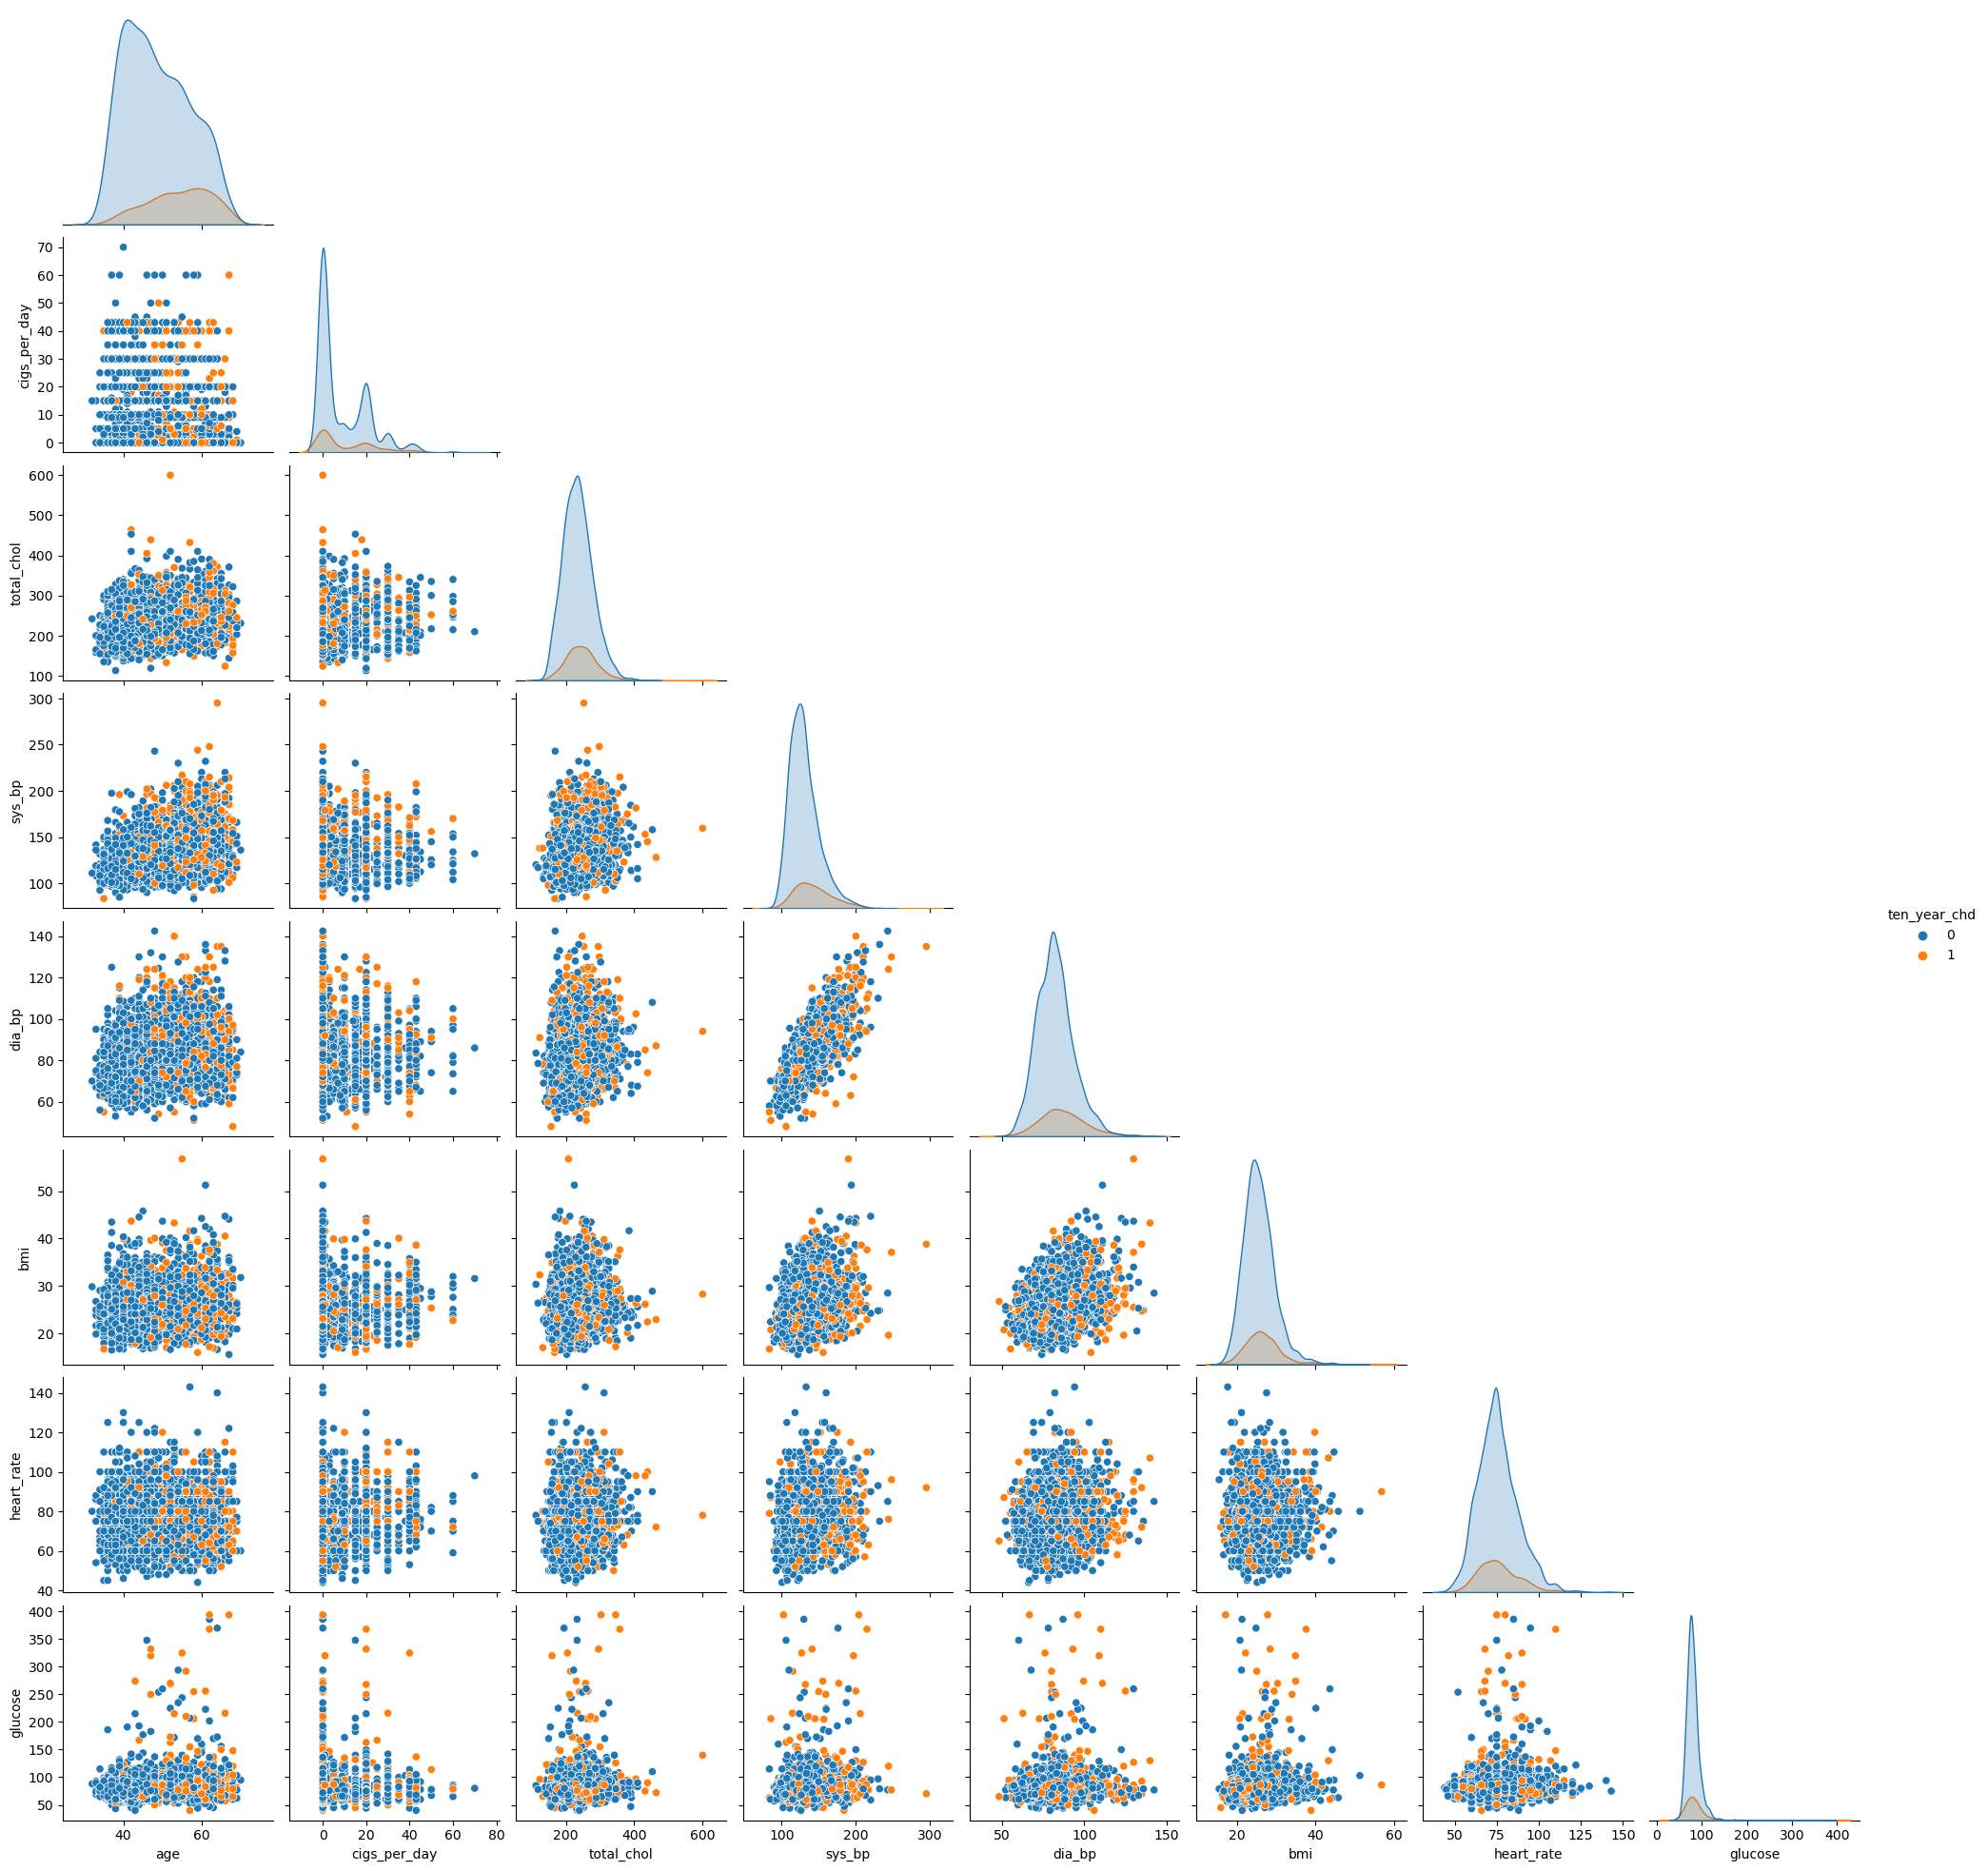

In [8]:
sns.pairplot(heart_df[list(heart_df.dtypes[(heart_df.dtypes == 'category') == False].index) + ['ten_year_chd']],
             hue = 'ten_year_chd', corner = True)
plt.show()

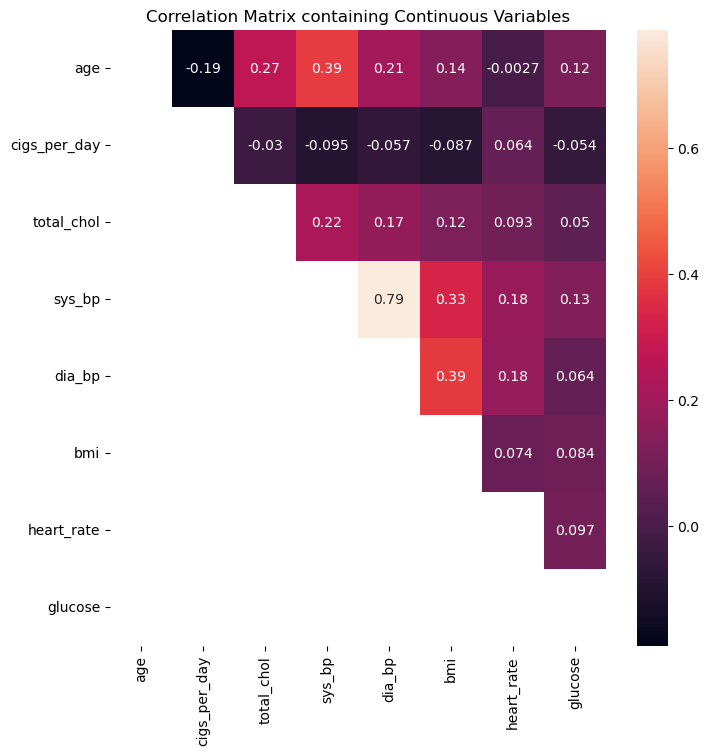

In [9]:
mask = np.zeros_like(heart_df.select_dtypes(exclude = ['category']).corr())
mask[np.tril_indices_from(mask)] = 1
plt.figure(figsize=(8, 8))
sns.heatmap(heart_df.select_dtypes(exclude = ['category']).corr(), mask = mask, annot = True, square = False)
plt.title('Correlation Matrix containing Continuous Variables')
plt.show()

## Explanation of Variance Inflation Factor (VIF) Calculation

The code below calculates the Variance Inflation Factor (VIF) for each variable in the dataset. VIF is a measure of how much the variance of an estimated regression coefficient increases if your predictors are correlated. High VIF values indicate high multicollinearity.

### Steps:

1. **Add a Constant Term:**
   - The `add_constant` function adds a constant term (intercept) to the dataset. This is necessary when calculating VIF.

2. **Select Numeric Variables:**
   - The code then selects numeric variables, excluding categorical variables, from the dataset.

3. **Calculate VIF:**
   - The VIF is calculated for each numeric variable using the `variance_inflation_factor` function from the statsmodels library. The result is a Pandas Series with VIF values indexed by variable names.


In [10]:
X = add_constant(heart_df)
X = X.select_dtypes(exclude = ['category'])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index = X.columns)

const           127.752134
age               1.315494
cigs_per_day      1.048542
total_chol        1.106154
sys_bp            3.109630
dia_bp            2.860657
bmi               1.190182
heart_rate        1.062395
glucose           1.038703
dtype: float64

None of the continuous variables are correlated as the highest VIF is less than 10.

### Preprocessing

## Data Preprocessing for Binary Classification

The code below demonstrates a series of preprocessing steps for a binary classification problem using the `heart_df` dataset.

### Steps:

1. **Create a Copy of the DataFrame:**
   - The variable `full_df` is created as a copy of the original DataFrame `heart_df`.

2. **One-Hot Encoding for Education:**
   - The code uses `pd.get_dummies` to perform one-hot encoding on the 'education' column, creating dummy variables prefixed with 'edu:'. The original 'education' column is dropped.

3. **Concatenate DataFrames:**
   - The one-hot encoded education variables and selected binary columns ('male', 'current_smoker', 'bp_meds', 'prevalent_stroke', 'prevalent_hyper', 'diabetes') are concatenated into a new DataFrame named `full_ddf`.

4. **Drop Unnecessary Columns:**
   - The selected binary columns and the 'education' column are dropped from the original DataFrame (`full_df`).

5. **Prepare Target Variable:**
   - The target variable 'ten_year_chd' is stored in a separate DataFrame `c` for classification.

6. **Drop Target Variable:**
   - The 'ten_year_chd' column is dropped from the original DataFrame.

7. **Feature Normalization:**
   - The function `featureNormalize` is defined to standardize the features by subtracting the mean and dividing by the standard deviation.

8. **Concatenate Normalized Features:**
   - Two DataFrames (`X1` and `X2`) are created by concatenating the standardized features and the one-hot encoded education variables. `X1` uses mean normalization, while `X2` retains the original scale.



In [11]:
full_df = heart_df

full_ddf = pd.get_dummies(full_df['education'], drop_first = True, prefix = 'edu:')
full_ddf = pd.concat([full_ddf, full_df[['male', 'current_smoker', 'bp_meds', 'prevalent_stroke',
                                         'prevalent_hyper', 'diabetes']]], axis = 1)

full_df = full_df.drop(['education', 'male', 'current_smoker', 'bp_meds', 'prevalent_stroke',
                        'prevalent_hyper', 'diabetes'], axis = 1)

c = pd.DataFrame(full_df['ten_year_chd']).reset_index(drop = True)

full_df = full_df.drop('ten_year_chd', axis = 1)

def featureNormalize(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0, ddof = 1)

X1 = pd.concat([featureNormalize(full_df), full_ddf], axis = 1).reset_index(drop = True)
X2 = pd.concat([full_df, full_ddf], axis = 1).reset_index(drop = True)

## Train-Test Split for Binary Classification

The code below demonstrates the process of splitting the data into training and testing sets for binary classification. Two sets of features (`X1` and `X2`) along with the corresponding target variable (`c`) are split into training and testing sets.

### Steps:

1. **Random Sampling for Training Set:**
   - `X1_train` is created by randomly sampling 70% of the data using `sample` with a specified random seed (`random_state=42`). The indices are sorted to maintain the original order.

2. **Select Corresponding Rows in X2 and c for Training Set:**
   - `X2_train` and `c_train` are created by selecting rows from `X2` and `c` that correspond to the indices in `X1_train`.

3. **Create Test Sets:**
   - `X1_test`, `X2_test`, and `c_test` are created by selecting the rows that are not in the training set.



In [12]:
X1_train = X1.sample(random_state = 42, frac = 0.7).sort_index()
X2_train = X2[X1.index.isin(X1_train.index)]
c_train = c[X1.index.isin(X1_train.index)]
X1_test = X1[~X1.index.isin(X1_train.index)]
X2_test = X2[~X1.index.isin(X1_train.index)]
c_test = c[~X1.index.isin(X1_train.index)]

### Support Vector Classification using Linear Kernel

### Decision Tree Classification

Let's take a small portion of dataset and train a Decision Tree model

## Decision Tree Classifier Training and Prediction

The code below demonstrates the use of the `DecisionTreeClassifier` from scikit-learn for training and predicting on a binary classification task. The dataset is split into training and testing sets using the `train_test_split` function.

### Steps:

1. **Train-Test Split:**
   - The dataset (`X2_train` and `c_train`) is split into training and testing sets using the `train_test_split` function from scikit-learn. The testing set comprises 30% of the data.

2. **Initialize Decision Tree Classifier:**
   - An instance of the `DecisionTreeClassifier` is created with the following parameters:
     - `criterion`: The function to measure the quality of a split ("entropy" in this case).
     - `random_state`: A seed for reproducibility.
     - `class_weight`: The "balanced" option adjusts the weights inversely proportional to class frequencies, which can be useful for imbalanced datasets.

3. **Fit the Model:**
   - The decision tree classifier (`dtd`) is trained on the training set (`X_train`, `y_train`) using the `fit` method.

4. **Make Predictions:**
   - Predictions (`pred`) are made on the testing set (`X_test`), using the trained model.



In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2_train,c_train, test_size=0.3)

dtd = DecisionTreeClassifier(criterion = "entropy", random_state = 42, class_weight = 'balanced')
dtd.fit(X_train, y_train)
pred = dtd.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(pred, y_test)

print("Accuracy:",accuracy)

Accuracy: 0.7282184655396619


We have used entropy method for creating the Decision tree we have gini method as well for growing tree. Lets explore the parameters of Decision Tree by running the traning as Hyper parameter Optimization

## Grid Search for Decision Tree Hyperparameter Tuning

The code below performs a grid search to find the optimal hyperparameters for a Decision Tree Classifier using the scikit-learn library. The grid search is conducted over different criteria, maximum depths, and minimum leaf samples. The Matthews Correlation Coefficient (MCC) is used as the scoring metric.

### Steps:

1. **Define Hyperparameter Grid:**
   - Lists of candidate values for hyperparameters (`dt_criterion`, `dt_max_depth_arr`, `dt_min_leaf_arr`) are defined. These include different criteria, maximum depths, and minimum leaf samples.

2. **Initialize Decision Tree and GridSearchCV:**
   - A Decision Tree Classifier with balanced class weights is initialized. `GridSearchCV` is then set up to perform cross-validated grid search over the hyperparameter space.

3. **Perform Grid Search:**
   - The `fit` method of `GridSearchCV` is called on the training data (`X2_train`, `c_train`) to find the best hyperparameters based on the specified scoring metric (Matthews Correlation Coefficient).

4. **Create DataFrame from Results:**
   - The results of the grid search are stored in a Pandas DataFrame (`dt_df`), which includes information about the hyperparameters, cross-validated scores, and training times.




In [15]:
dt_criterion = ['gini','entropy']
dt_max_depth_arr = np.linspace(1, 10, 10).astype(int)
dt_min_leaf_arr = np.linspace(1, 10, 10).astype(int)

dt = GridSearchCV(DecisionTreeClassifier(random_state = 42, class_weight = 'balanced'),
                  param_grid = {'criterion': dt_criterion,
                                'max_depth' : dt_max_depth_arr,
                                'min_samples_leaf' : dt_min_leaf_arr},
                  scoring = mcc, cv = 5, return_train_score = True)

dt.fit(X2_train, c_train)

dt_df = pd.DataFrame(dt.cv_results_)

## Visualizing Decision Tree Hyperparameter Tuning Results

The code below generates heatmaps to visualize the Matthews Correlation Coefficient (MCC) scores for different combinations of hyperparameters during the grid search for a Decision Tree Classifier. Two sets of heatmaps are created: one for training data and one for cross-validated data.

### Steps:

1. **Create Subplots:**
   - Two subplots (`fig, axs`) are initialized to visualize the training and cross-validated MCC scores side by side.

2. **Generate Heatmaps for Training Data:**
   - For each criterion ('gini' and 'entropy'), a heatmap is created to display the MCC scores on the training data for various combinations of maximum depth and minimum leaf samples.

3. **Generate Heatmaps for Cross-Validated Data:**
   - Similar to the training data, heatmaps are generated to visualize the cross-validated MCC scores for different hyperparameter combinations.

4. **Show Plots:**
   - The two sets of heatmaps are displayed in separate subplots.




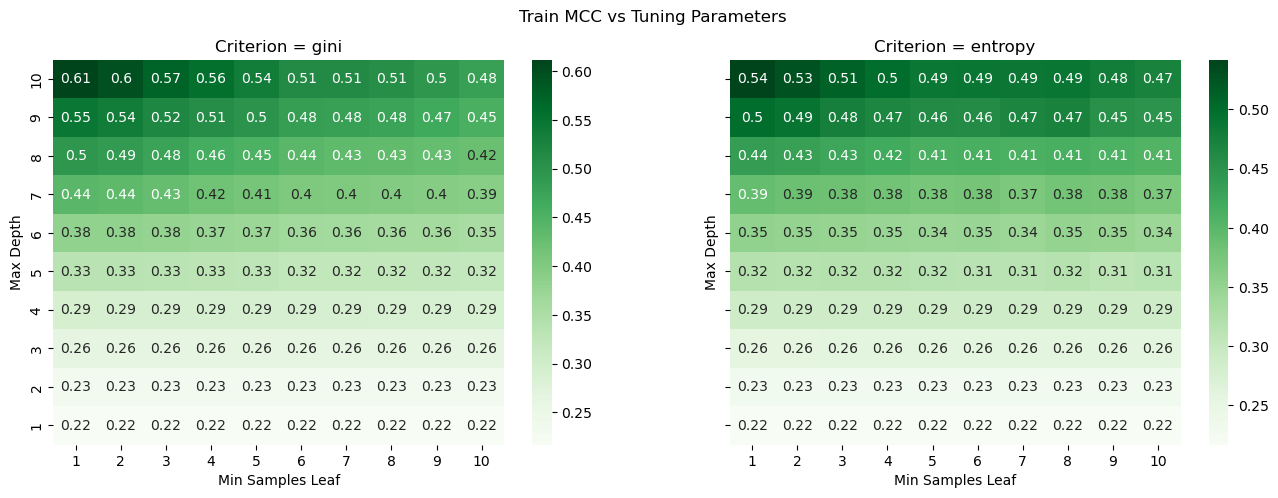

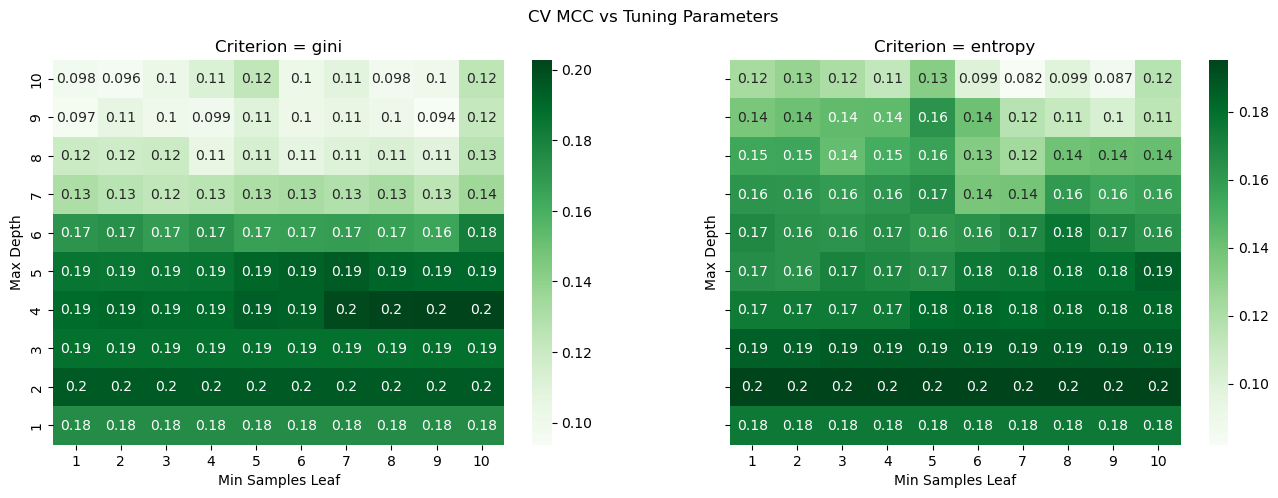

In [16]:
fig, axs = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (16, 5))
for ax, criterion in zip(axs.ravel(), dt_criterion):
    dt_criterion_df = dt_df[dt_df['param_criterion'] == criterion]
    dt_criterion_train_err_mat = dt_criterion_df['mean_train_score'].values.reshape(len(dt_max_depth_arr),
                                                                                    len(dt_min_leaf_arr))
    ax = sns.heatmap(pd.DataFrame(dt_criterion_train_err_mat, columns = dt_min_leaf_arr,
                                  index = dt_max_depth_arr).iloc[::-1], ax = ax, annot = True, cmap = 'Greens')
    ax.set(xlabel = 'Min Samples Leaf', ylabel = 'Max Depth', title = 'Criterion = ' + str(criterion))
fig.suptitle('Train MCC vs Tuning Parameters')
plt.show()

fig, axs = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (16, 5))
for ax, criterion in zip(axs.ravel(), dt_criterion):
    dt_criterion_df = dt_df[dt_df['param_criterion'] == criterion]
    dt_criterion_cv_err_mat = dt_criterion_df['mean_test_score'].values.reshape(len(dt_max_depth_arr), len(dt_min_leaf_arr))
    ax = sns.heatmap(pd.DataFrame(dt_criterion_cv_err_mat, columns = dt_min_leaf_arr,
                                  index = dt_max_depth_arr).iloc[::-1], ax = ax, annot = True, cmap = 'Greens')
    ax.set(xlabel = 'Min Samples Leaf', ylabel = 'Max Depth', title = 'Criterion = ' + str(criterion))
fig.suptitle('CV MCC vs Tuning Parameters')
plt.show()

## Evaluate Decision Tree Classifier Performance

The code below evaluates the performance of a Decision Tree Classifier by printing the best hyperparameters and cross-validation Matthews Correlation Coefficient (MCC), generating a confusion matrix, and calculating additional performance metrics on the test set.

### Steps:

1. **Print Best Hyperparameters:**
   - The best hyperparameters found during the grid search are printed using `dt.best_params_`.

2. **Print Best Cross-Validation MCC:**
   - The best cross-validated Matthews Correlation Coefficient (MCC) score is printed using `dt.best_score_`.

3. **Make Predictions on Test Set:**
   - Predictions are made on the test set using the best-tuned decision tree model.

4. **Generate Confusion Matrix:**
   - A confusion matrix is created to show the number of true positives, true negatives, false positives, and false negatives.

5. **Visualize Confusion Matrix:**
   - The confusion matrix is visualized using a heatmap.

6. **Print Additional Performance Metrics:**
   - Accuracy, sensitivity, and specificity are printed as additional performance metrics.




Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 9}
Best Cross-Validation MCC: 0.20


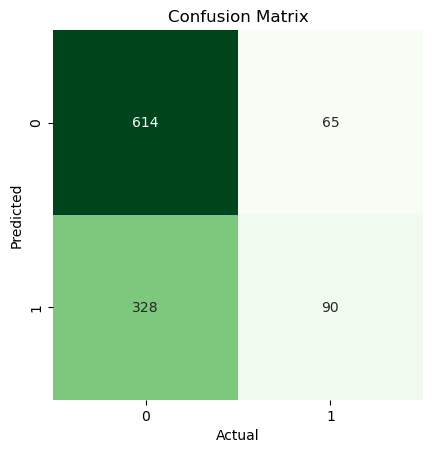

Accuracy: 0.64
Sensitivity: 0.58
Specificity: 0.65


In [17]:
print("Best Parameters: {}".format(dt.best_params_))
print("Best Cross-Validation MCC: {:.2f}".format(dt.best_score_))

pred_dt = dt.predict(X2_test)


cm_dt = confusion_matrix(c_test, pred_dt)
tn, fp, fn, tp = cm_dt.ravel()

ax = sns.heatmap(cm_dt.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_dt)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

Now Lets Visualize the Structure of the Decision Tree

## Visualize Decision Tree Structure

The code below visualizes the structure of the best-tuned Decision Tree Classifier by plotting the decision tree with the most important hyperparameters.

### Steps:

1. **Initialize Decision Tree with Best Hyperparameters:**
   - A new instance of the Decision Tree Classifier is created using the best hyperparameters obtained from the grid search.

2. **Fit the Decision Tree on Training Data:**
   - The decision tree is fitted on the training data using the best hyperparameters.

3. **Plot the Decision Tree:**
   - The `plot_tree` function from scikit-learn is used to visualize the decision tree. The feature names and class names are provided for better interpretation. The plot is customized to show filled nodes.

4. **Print Decision Tree Structure (Optional):**
   - The `export_text` function can be used to print the textual representation of the decision tree structure. This line is commented out in the code.



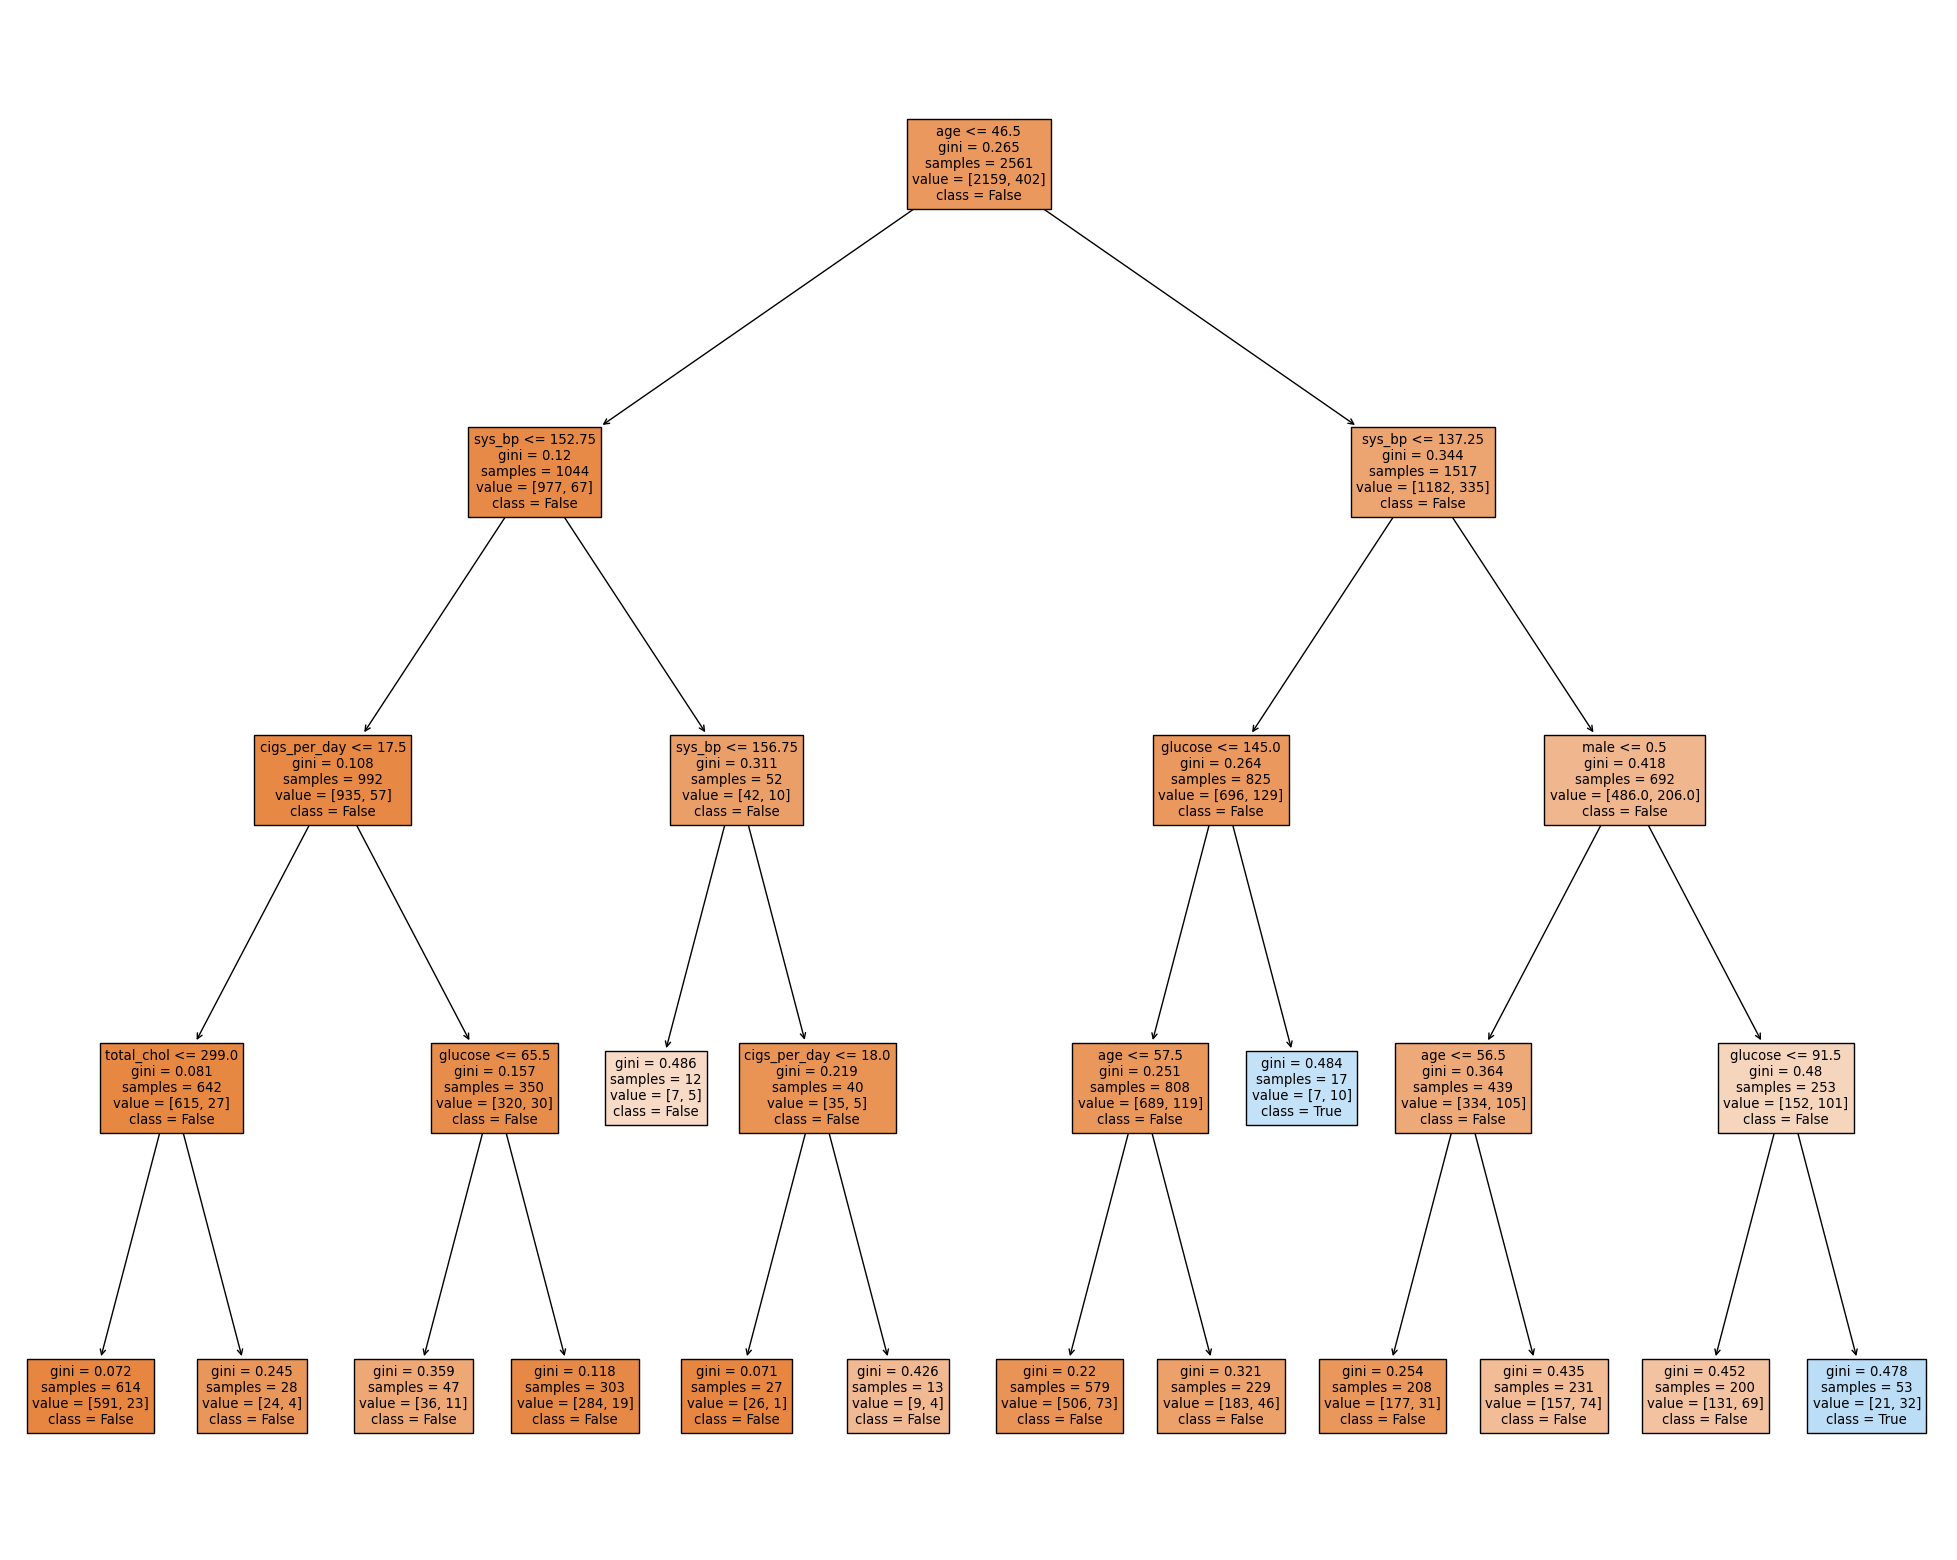

In [18]:
plot_dt = DecisionTreeClassifier(random_state = 42, criterion = dt.best_params_['criterion'],
                                 max_depth = dt.best_params_['max_depth'],
                                 min_samples_leaf = dt.best_params_['min_samples_leaf'])
plot_dt.fit(X2_train, c_train)

fig = plt.figure(figsize=(25, 20))
_ = plot_tree(plot_dt, feature_names = list(X2_train.columns), class_names = ['False', 'True'], filled = True)

# print(export_text(plot_dt, feature_names = list(X2_train.columns)))

### Decision Tree Classification with Cost Complexity Pruning

Decision trees are a popular and intuitive method for supervised learning, especially for classification problems. They are easy to interpret and can handle both categorical and numerical features. However, decision trees can also suffer from overfitting, which means that they learn too much from the training data and do not generalize well to new data. Overfitting can result in complex and deep trees that have low accuracy and high variance.

One way to prevent overfitting in decision trees is to use pruning, which is a technique that reduces the size and complexity of a tree by removing some of its nodes or branches. Pruning can be done either before or after the tree is fully grown, which are called pre-pruning and post-pruning, respectively. Pre-pruning stops the tree from growing further when a certain criterion is met, such as a minimum number of samples in a node or a maximum depth of the tree. Post-pruning removes nodes or branches from a fully grown tree based on some measure of their importance or relevance.

Cost complexity pruning is a post-pruning technique that works by calculating a Tree Score based on Residual Sum of Squares (RSS) for the subtree, and a Tree Complexity Penalty that is a function of the number of leaves in the subtree.

## Cost-Complexity Pruning Path for Decision Tree

The code below explores the cost-complexity pruning path of a Decision Tree Classifier. This path helps in identifying the optimal values of the hyperparameter `alpha`, which controls the level of pruning. Pruning is a technique to prevent overfitting by limiting the growth of the tree.

### Steps:

1. **Initialize Decision Tree without Pruning:**
   - A Decision Tree Classifier (`ccpdt`) is initialized without specifying any hyperparameters related to pruning.

2. **Compute the Cost-Complexity Pruning Path:**
   - The `cost_complexity_pruning_path` method is used on the training data (`X2_train`, `c_train`) to compute the pruning path. This method returns arrays of alphas (effective complexity parameters) and impurities.

3. **Plot the Pruning Path:**
   - The computed alphas and impurities are plotted to visualize the relationship between the effective alpha and the total impurity of leaves. The x-axis is scaled logarithmically for better visibility.




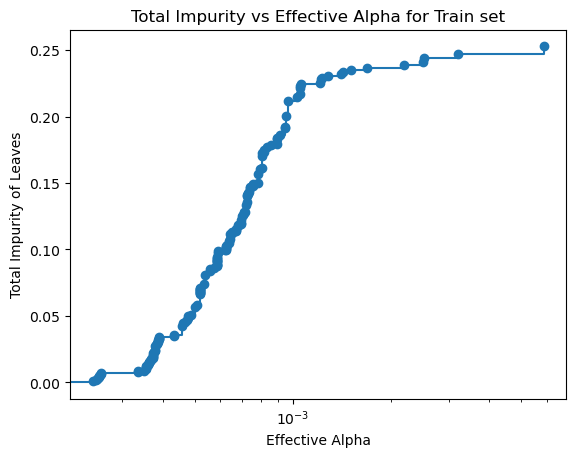

In [19]:
ccpdt = DecisionTreeClassifier(random_state = 42)
ccpdt_path = ccpdt.cost_complexity_pruning_path(X2_train, c_train)
ccpdt_alphas, ccpdt_impurities = ccpdt_path.ccp_alphas, ccpdt_path.impurities

plt.plot(ccpdt_alphas[:-1], ccpdt_impurities[:-1], marker = 'o', drawstyle = 'steps-post')
plt.xscale('log')
plt.xlabel('Effective Alpha')
plt.ylabel('Total Impurity of Leaves')
plt.title('Total Impurity vs Effective Alpha for Train set')
plt.show()

## Prune Decision Tree using Cost-Complexity Pruning

The code below uses the cost-complexity pruning path obtained from the training set to find the optimal value of `ccp_alpha` for pruning a Decision Tree Classifier. A grid search is performed to find the best alpha value based on the Matthews Correlation Coefficient (MCC).

### Steps:

1. **Initialize Pruned Decision Tree:**
   - A new Decision Tree Classifier (`pdt`) is initialized with the option for balanced class weights.

2. **Perform Grid Search for Optimal Alpha:**
   - The `GridSearchCV` is used to perform a grid search over the range of `ccp_alpha` values obtained from the cost-complexity pruning path.

3. **Create DataFrame from Grid Search Results:**
   - The results of the grid search, including different alpha values and corresponding MCC scores, are stored in a Pandas DataFrame (`pdt_df`).



In [20]:
pdt = GridSearchCV(DecisionTreeClassifier(random_state = 42, class_weight = 'balanced'),
                  param_grid = {'ccp_alpha': ccpdt_alphas[:-1]},
                  scoring = mcc, cv = 5, return_train_score = True)

pdt.fit(X2_train, c_train)

pdt_df = pd.DataFrame(pdt.cv_results_)

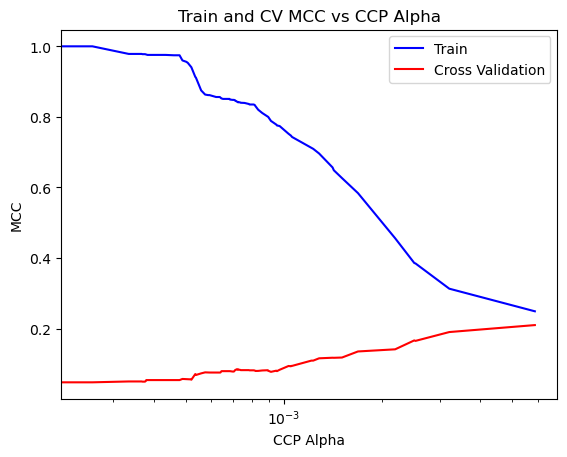

In [21]:
plt.plot(pdt_df['param_ccp_alpha'], pdt_df['mean_train_score'], c = 'b', label = 'Train')
plt.plot(pdt_df['param_ccp_alpha'], pdt_df['mean_test_score'], c = 'r', label = 'Cross Validation')
plt.xscale('log')
plt.legend(loc = 1)
plt.xlabel('CCP Alpha')
plt.ylabel('MCC')
plt.title('Train and CV MCC vs CCP Alpha')
plt.show()

Best Parameters: {'ccp_alpha': 0.005869864875948788}
Best Cross-Validation MCC: 0.21


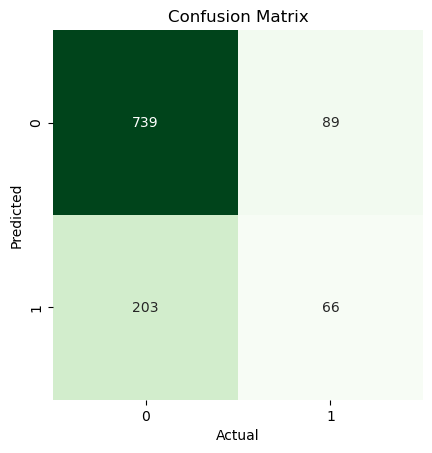

Accuracy: 0.73
Sensitivity: 0.43
Specificity: 0.78


In [22]:
print("Best Parameters: {}".format(pdt.best_params_))
print("Best Cross-Validation MCC: {:.2f}".format(pdt.best_score_))

pred_pdt = pdt.predict(X2_test)

cm_pdt = confusion_matrix(c_test, pred_pdt)
tn, fp, fn, tp = cm_pdt.ravel()

ax = sns.heatmap(cm_pdt.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_pdt)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## Adaboost Decision Tree

Adaboost is a popular and powerful ensemble learning technique that combines multiple weak learners (such as decision trees) to create a strong learner. Adaboost stands for Adaptive Boosting, which means that it adapts the weights of the training samples and the learners based on the performance of the previous learners. Adaboost can be used for both classification and regression problems, and it has several advantages, such as:

- It is easy to implement and does not require much parameter tuning.
- It can handle both categorical and numerical features, and can deal with missing values and outliers.
- It can improve the accuracy and reduce the variance of a single decision tree, and can avoid overfitting by limiting the depth of the trees.
- It can handle imbalanced data sets by focusing more on the minority class.

The basic idea of Adaboost is to fit a sequence of weak learners (such as decision trees with one level, also called decision stumps) on repeatedly re-sampled versions of the data. Each sample carries a weight that is adjusted after each training step, such that misclassified samples will be assigned higher weights, and correctly classified samples will be assigned lower weights. This way, the subsequent learners will focus more on the difficult cases, and the final prediction will be a weighted majority vote (for classification) or a weighted average (for regression) of the individual learners.

An AdaBoost decision tree classifier is a machine learning technique that combines multiple decision trees to make better predictions than a single decision tree. A decision tree is a simple way to make predictions based on a set of rules, where each node represents a question or condition, and each branch represents a possible answer or outcome. For example, here is a decision tree that predicts whether a person likes chocolate or not, based on their age and gender:

An AdaBoost decision tree classifier works by creating many decision trees from different subsets of the data and features, and then combining their predictions by voting or averaging. The subsets of the data and features are created by using random sampling with replacement, which means that some data points or features may be repeated or omitted in each subset. This adds diversity and reduces correlation among the decision trees, making the AdaBoost decision tree classifier more robust and accurate.

For example, suppose we have a dataset of 100 people and their preferences for chocolate, and we want to create an AdaBoost decision tree classifier of 10 decision trees. We can do this by randomly selecting 80 people and 2 features (out of 3) for each decision tree, and then training each decision tree on its own subset. Here is what the AdaBoost decision tree classifier might look like:

To use the AdaBoost decision tree classifier to make a prediction for a new person who is female and 25 years old, we would pass the new person’s data to each decision tree in the AdaBoost decision tree classifier, and get their predictions. For example, the first decision tree might predict yes, the second decision tree might predict no, and so on. We would then aggregate the predictions of all the decision trees by voting or averaging. For example, if 6 out of 10 decision trees predict yes, and 4 out of 10 decision trees predict no, we would take the majority vote and predict yes. Alternatively, if each decision tree gives a probability of yes or no, we would take the average of all the probabilities and predict the class with the highest probability.

Adaboost can be implemented using the `AdaBoostClassifier` and `AdaBoostRegressor` classes in scikit-learn, which provide various parameters to control the behavior of the algorithm, such as the number of learners, the learning rate, the base estimator, and the random state. Adaboost can also be combined with other types of weak learners, such as support vector machines, neural networks, or k-nearest neighbors, but the most common and effective choice is decision trees. Adaboost can also be extended to handle multi-class classification problems, using algorithms such as SAMME (Stagewise Additive Modeling using a Multi-class Exponential loss function) or SAMME.R (SAMME with Real values), which are also implemented in scikit-learn.


In [23]:
adt_learning_rate_arr = np.logspace(-4, 0, 5)
adt_n_estimators_arr = [10, 20, 50, 100, 200, 500, 1000]

adt = GridSearchCV(AdaBoostClassifier(random_state = 42),
                   param_grid = {'learning_rate' : adt_learning_rate_arr, 'n_estimators' : adt_n_estimators_arr},
                   scoring = mcc, cv = 5, return_train_score = True)

adt.fit(X2_train.values, c_train.values.ravel())

adt_df = pd.DataFrame(adt.cv_results_)

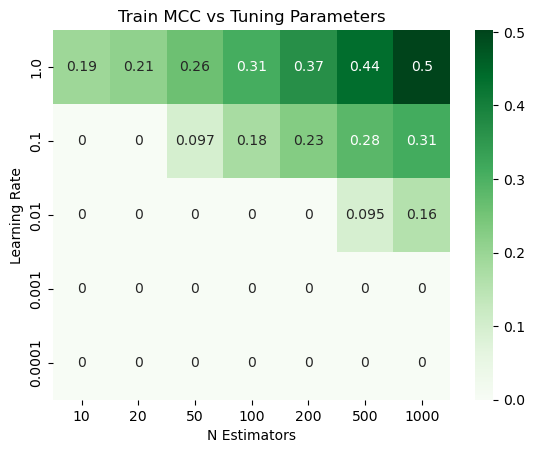

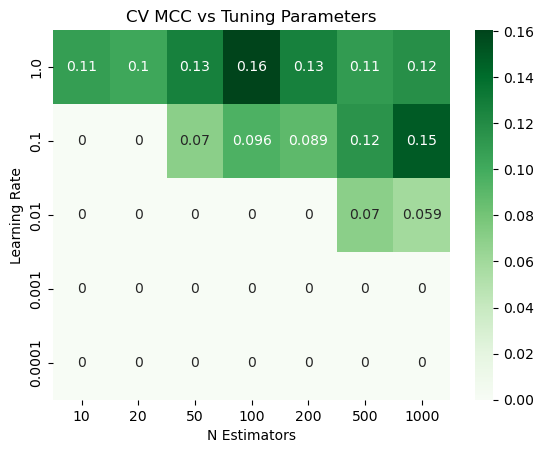

In [24]:
adt_train_err_mat = adt_df['mean_train_score'].values.reshape(len(adt_learning_rate_arr), len(adt_n_estimators_arr))
ax = sns.heatmap(pd.DataFrame(adt_train_err_mat, columns = adt_n_estimators_arr, index = adt_learning_rate_arr).iloc[::-1],
                 annot = True, cmap = 'Greens')
ax.set(xlabel = 'N Estimators', ylabel = 'Learning Rate', title = 'Train MCC vs Tuning Parameters')
plt.show()

adt_cv_err_mat = adt_df['mean_test_score'].values.reshape(len(adt_learning_rate_arr), len(adt_n_estimators_arr))
ax = sns.heatmap(pd.DataFrame(adt_cv_err_mat, columns = adt_n_estimators_arr, index = adt_learning_rate_arr).iloc[::-1],
                 annot = True, cmap = 'Greens')
ax.set(xlabel = 'N Estimators', ylabel = 'Learning Rate', title = 'CV MCC vs Tuning Parameters')
plt.show()

Best Parameters: {'learning_rate': 1.0, 'n_estimators': 100}
Best Cross-Validation MCC: 0.16


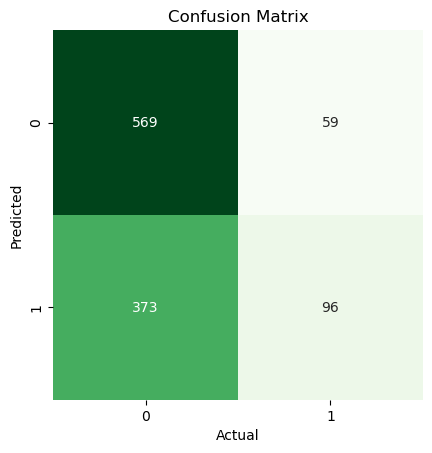

Accuracy: 0.61
Sensitivity: 0.62
Specificity: 0.60


In [25]:
print("Best Parameters: {}".format(adt.best_params_))
print("Best Cross-Validation MCC: {:.2f}".format(adt.best_score_))

pred_adt = (adt.predict_proba(X2_test)[:,1] >= 0.495).astype(bool)



cm_adt = confusion_matrix(c_test, pred_adt)
tn, fp, fn, tp = cm_adt.ravel()

ax = sns.heatmap(cm_adt.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_adt)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## Random Forest Classification

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a simple RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the validation set: {accuracy:.4f}")

Accuracy on the validation set: 0.8309


## Hyper Parameter Optimization on RandomForest Classification

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the random forest parameters
rf_n_estimators_arr = [10, 20, 50, 100, 200, 500, 1000]
rf_max_depth_arr = [None, 10, 20, 30, 40, 50]  # Add max_depth as the second hyperparameter

rf = GridSearchCV(RandomForestClassifier(random_state=42),
                   param_grid={'n_estimators': rf_n_estimators_arr, 'max_depth': rf_max_depth_arr},
                   scoring=mcc, cv=5, return_train_score=True)

rf.fit(X2_train.values, c_train.values.ravel())



GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'n_estimators': [10, 20, 50, 100, 200, 500, 1000]},
             return_train_score=True,
             scoring=make_scorer(custom_scorer, response_method='predict', actual_scorer=<function matthews_corrcoef at 0x0000023867C06FC0>))

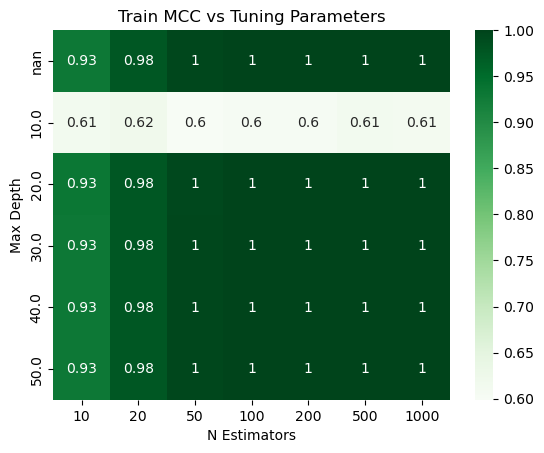

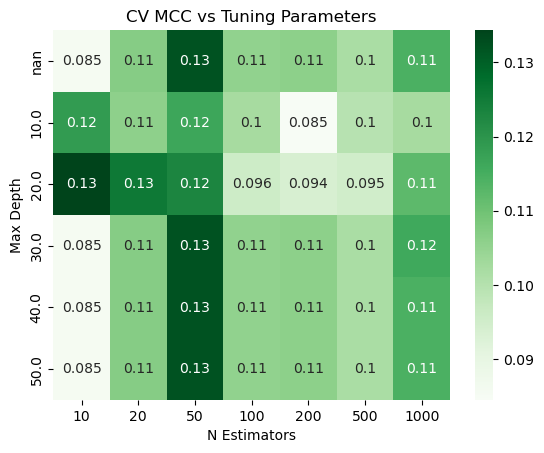

In [28]:
# Visualize Train MCC vs Tuning Parameters
rf_df_train = pd.DataFrame(rf.cv_results_)['mean_train_score'].values
rf_train_err_mat = rf_df_train.reshape(len(rf_max_depth_arr), len(rf_n_estimators_arr))
ax = sns.heatmap(pd.DataFrame(rf_train_err_mat, columns=rf_n_estimators_arr, index=rf_max_depth_arr),
                 annot=True, cmap='Greens')
ax.set(xlabel='N Estimators', ylabel='Max Depth', title='Train MCC vs Tuning Parameters')
plt.show()

# Visualize CV MCC vs Tuning Parameters
rf_df_cv = pd.DataFrame(rf.cv_results_)['mean_test_score'].values
rf_cv_err_mat = rf_df_cv.reshape(len(rf_max_depth_arr), len(rf_n_estimators_arr))
ax = sns.heatmap(pd.DataFrame(rf_cv_err_mat, columns=rf_n_estimators_arr, index=rf_max_depth_arr),
                 annot=True, cmap='Greens')
ax.set(xlabel='N Estimators', ylabel='Max Depth', title='CV MCC vs Tuning Parameters')
plt.show()



